In [1]:
from __future__ import print_function

from collections import defaultdict
import json
import requests

from IPython.display import Image
import networkx as nx

from py2cytoscape.util import from_networkx

In [2]:
def get_psiquic_uniprot(query, **kwargs):
    kwargs['format'] = kwargs.get('format', 'tab27')
    server = 'http://www.ebi.ac.uk/Tools/webservices/psicquic/uniprot/webservices/current/search/query'
    req = requests.get('%s/%s' % (server, query), params=kwargs)
    if not req.ok:
        req.raise_for_status()
    return req.content

In [51]:
genes_species = defaultdict(set)
interactions = {}

def get_gene_name(my_id, alt_names):
    toks = alt_names.split('|')
    for tok in toks:
        if tok.endswith('(gene name)'):
            return tok[tok.find(':') + 1: tok.find('(')]
    return my_id + '?'  # no name...

def get_vernacular_tax(tax):
    return tax.split('|')[0][tax.find('(') + 1:-1]

def add_interactions(species):
    for rec in species.split('\n'):
        toks = rec.rstrip().split('\t')
        if len(toks) < 15:
            continue  # empty line at the end
        id1 = toks[0][toks[0].find(':') + 1:]
        id2 = toks[1][toks[1].find(':') + 1:]
        gene1, gene2 = get_gene_name(id1, toks[4]), get_gene_name(id2, toks[5])
        #print(toks[6])

        tax1, tax2 = get_vernacular_tax(toks[9]), get_vernacular_tax(toks[10])
        inter_type = toks[11][toks[11].find('(') + 1:-1]
        miscore = float(toks[14].split(':')[1])
        genes_species[tax1].add(gene1)
        genes_species[tax2].add(gene2)
        interactions[((tax1, gene1), (tax2, gene2))] = {'score': miscore, 'type': inter_type}

In [ ]:
human = get_psiquic_uniprot('uniprotkb:P04637')
add_interactions(human)
rat = get_psiquic_uniprot('uniprotkb:P10361')
add_interactions(rat)
mouse = get_psiquic_uniprot('uniprotkb:P02340')
add_interactions(mouse)

In [64]:
requests.delete(server + 'networks')

defaultdict(<type 'set'>, {'rat': set(['Tp53']), 'mouse': set(['Sirt1', 'Tp53', 'Bard1']), 'human': set(['HDAC3', 'WDR5', 'HUWE1', 'MEN1', 'USP7', 'FOXO3', 'MAGEC2', 'MAGEA2', 'XRCC6', 'DDX17', 'NOC2L', 'RPS19BP1', 'KMT2A', 'IFI16', 'PML', 'TOPORS', 'SIRT1', 'TRIM28', 'BARD1', 'MDM2', 'NPM1', 'UHRF2', 'KAT8', 'TP53', 'RBBP5', 'DDX5']), 'sv40': set(['P03070?'])})
{(('human', 'MAGEC2'), ('human', 'TP53')): {'score': 0.59, 'type': 'association'}, (('human', 'DDX5'), ('human', 'TP53')): {'score': 0.66, 'type': 'physical association'}, (('human', 'TP53'), ('human', 'DDX5')): {'score': 0.66, 'type': 'physical association'}, (('mouse', 'Bard1'), ('mouse', 'Tp53')): {'score': 0.4, 'type': 'physical association'}, (('human', 'TP53'), ('human', 'BARD1')): {'score': 0.4, 'type': 'physical association'}, (('human', 'UHRF2'), ('human', 'TP53')): {'score': 0.52, 'type': 'physical association'}, (('human', 'FOXO3'), ('human', 'TP53')): {'score': 0.59, 'type': 'physical association'}, (('human', 'TP53

<Response [204]>

rat
Tp53 Tp53 (r)
mouse
Sirt1 Sirt1 (m)
Tp53 Tp53 (m)
Bard1 Bard1 (m)
human
HDAC3 HDAC3
WDR5 WDR5
HUWE1 HUWE1
MEN1 MEN1
USP7 USP7
FOXO3 FOXO3
MAGEC2 MAGEC2
MAGEA2 MAGEA2
XRCC6 XRCC6
DDX17 DDX17
NOC2L NOC2L
RPS19BP1 RPS19BP1
KMT2A KMT2A
IFI16 IFI16
PML PML
TOPORS TOPORS
SIRT1 SIRT1
TRIM28 TRIM28
BARD1 BARD1
MDM2 MDM2
NPM1 NPM1
UHRF2 UHRF2
KAT8 KAT8
TP53 TP53
RBBP5 RBBP5
DDX5 DDX5
sv40
P03070? P03070? (sv40)
[{'data': {'species': 'human', 'name': 'HDAC3', 'id': 'HDAC3'}}, {'data': {'species': 'human', 'name': 'WDR5', 'id': 'WDR5'}}, {'data': {'species': 'human', 'name': 'HUWE1', 'id': 'HUWE1'}}, {'data': {'species': 'human', 'name': 'SIRT1', 'id': 'SIRT1'}}, {'data': {'species': 'human', 'name': 'USP7', 'id': 'USP7'}}, {'data': {'species': 'human', 'name': 'FOXO3', 'id': 'FOXO3'}}, {'data': {'species': 'human', 'name': 'MAGEC2', 'id': 'MAGEC2'}}, {'data': {'species': 'mouse', 'name': 'Sirt1 (m)', 'id': 'Sirt1 (m)'}}, {'data': {'species': 'human', 'name': 'MAGEA2', 'id': 'MAGEA2'}}, {'dat

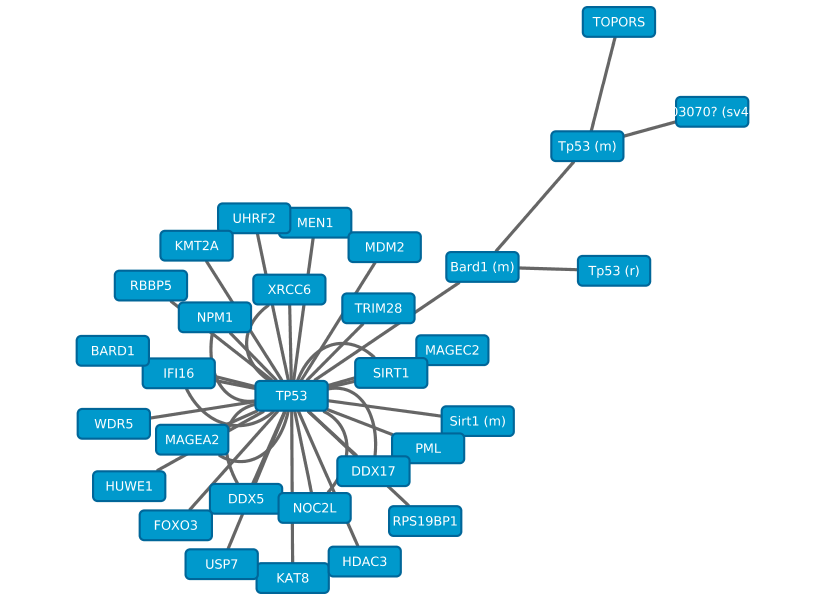

In [65]:
def get_node_label(species, gene):
    if species == 'human':
        return gene
    elif species in ['mouse', 'rat']:
        return '%s (%s)' % (gene, species[0])
    else:
        return  '%s (%s)' % (gene, species)

graph = nx.MultiGraph()
for species, genes in genes_species.items():
    print(species)
    for gene in genes:
        name = get_node_label(species, gene)
        print(gene, name)
        graph.add_node(get_node_label(species, gene),
                       attr_dict={'species': species})

for (i1, i2), attribs in interactions.items():
    tax1, gene1 = i1
    tax2, gene2 = i2
    #print(attribs)
    graph.add_edge(get_node_label(tax1, gene1),
                   get_node_label(tax2, gene2),
                   attr_dict={'interaction': attribs['type'],
                              'score': attribs['score']})

server = 'http://localhost:1234/v1/'

p53_interactions = from_networkx(graph)
print(p53_interactions['elements']['nodes'])
print(p53_interactions['elements']['edges'])
res1 = requests.post(server + 'networks', data=json.dumps(p53_interactions),
                     headers={'Content-Type': 'application/json'})
if not res1.ok:
        res1.raise_for_status()
net_id = res1.json()['networkSUID']
requests.get(server + 'apply/layouts/force-directed/' + str(net_id))
#change layout here
Image(server + 'networks/%s/views/first.png' % net_id)

In [74]:
res = requests.get(server + 'networks',
                     headers={'Content-Type': 'application/json'})
print(res.content)

'[52]'

In [24]:
res = requests.get(server + 'styles',
                     headers={'Content-Type': 'application/json'})
res.content
res = requests.get(server + 'styles/default black',
                     headers={'Content-Type': 'application/json'})
print(json.dumps(json.loads(res.content), indent=4))

'["Ripple","default black","Nested Network Style","default","Sample1","BioPAX","PSIMI 25 Style","Big Labels","Directed","Universe","Minimal","BioPAX_SIF","Solid"]'

In [ ]:
{'mappings': [
        {'mappingType': 'discrete',
         'map': [
           {'key': 'human' 'value': '#00FF00'},
           {'key': 'rat' 'value': '#FF00FF'},
           {'key': 'mouse' 'value': '#0000FF'}],
         'visualProperty': NODE_FILL_COLOR,
         'mappingColumnType': 'String',
         'mappingColumn: 'species'
        }, 
        {
            'mappingType': 'passthrough', 
            'visualProperty': 'NODE_LABEL', 
            'mappingColumnType': 'String', 
            'mappingColumn': 'label'
        }, 
        {
            'mappingType': 'passthrough', 
            'visualProperty': 'EDGE_TOOLTIP', 
            'mappingColumnType': 'String', 
            'mappingColumn': 'interaction'
        }
    ],
 'defaults': [
        {'visualProperty': 'EDGE_BEND', 'value': '#FFFFFF'}, 
    ]
}


In [ ]:
requests.get(server + 'apply/layouts/force-directed/' + str(net_id))
Image(server + 'networks/%s/views/first.png' % net_id) # this might be wrong, not first!
#or change view (clone)

# Old stuff

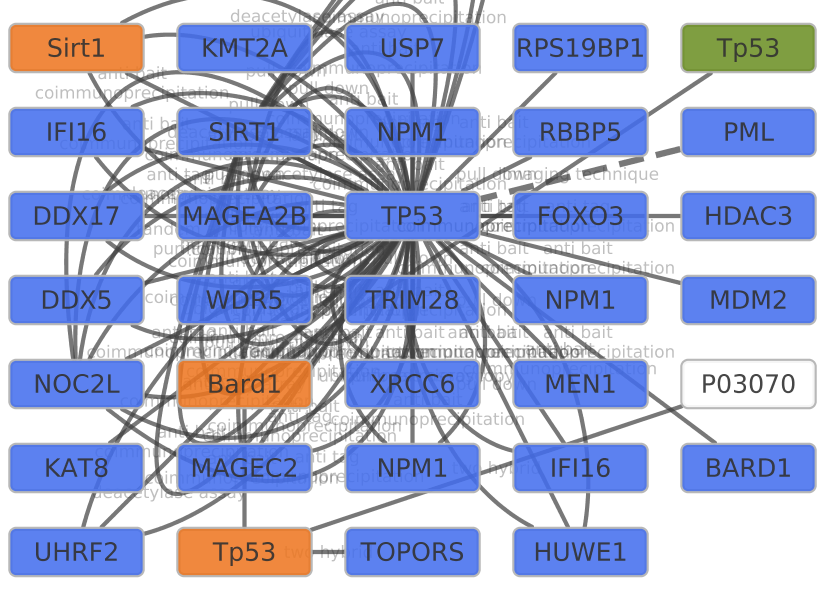

In [100]:
res = requests.get(server + 'apply/styles/PSIMI 25 Style/52',
                     headers={'Content-Type': 'application/json'})
res.content
if not res.ok:
        res.raise_for_status()
Image(server + 'networks/%s/views/first.png' % 52)

{
    "mappings": [
        {
            "mappingType": "discrete", 
            "map": [
                {
                    "value": "150.0", 
                    "key": "protein dna complex"
                }, 
                {
                    "value": "20.0", 
                    "key": "small molecule"
                }, 
                {
                    "value": "60.0", 
                    "key": "ribonucleic acid"
                }, 
                {
                    "value": "60.0", 
                    "key": "single stranded deoxyribonucleic acid"
                }, 
                {
                    "value": "150.0", 
                    "key": "complex composition"
                }, 
                {
                    "value": "60.0", 
                    "key": "double stranded deoxyribonucleic acid"
                }, 
                {
                    "value": "30.0", 
                    "key": "gene"
                }, 
                {
 